# SAR目标检测数据探索与可视化

本notebook用于探索SAR目标检测数据集，包括：
1. 随机选择训练图片并显示
2. 解析对应的标注文件
3. 在图片上绘制标注框，验证坐标解析的正确性


In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 设置数据路径
data_root = Path("../data")
train_images_dir = data_root / "train" / "images"
train_annfiles_dir = data_root / "train" / "annfiles"

print(f"训练图片目录: {train_images_dir}")
print(f"标注文件目录: {train_annfiles_dir}")
print(f"训练图片目录存在: {train_images_dir.exists()}")
print(f"标注文件目录存在: {train_annfiles_dir.exists()}")


训练图片目录: ..\data\train\images
标注文件目录: ..\data\train\annfiles
训练图片目录存在: True
标注文件目录存在: True


In [2]:
# 获取所有训练图片文件列表
image_files = list(train_images_dir.glob("*.png"))
print(f"总共找到 {len(image_files)} 张训练图片")

# 随机选择一张图片
if image_files:
    random_image_path = random.choice(image_files)
    image_name = random_image_path.stem  # 获取不带扩展名的文件名
    
    print(f"随机选择的图片: {random_image_path.name}")
    print(f"图片路径: {random_image_path}")
    
    # 构造对应的标注文件路径
    annotation_path = train_annfiles_dir / f"{image_name}.txt"
    print(f"对应的标注文件: {annotation_path}")
    print(f"标注文件存在: {annotation_path.exists()}")
else:
    print("未找到训练图片文件")


总共找到 89082 张训练图片
随机选择的图片: 051968.png
图片路径: ..\data\train\images\051968.png
对应的标注文件: ..\data\train\annfiles\051968.txt
标注文件存在: True


图片尺寸: (256, 256, 3)
图片类型: uint8


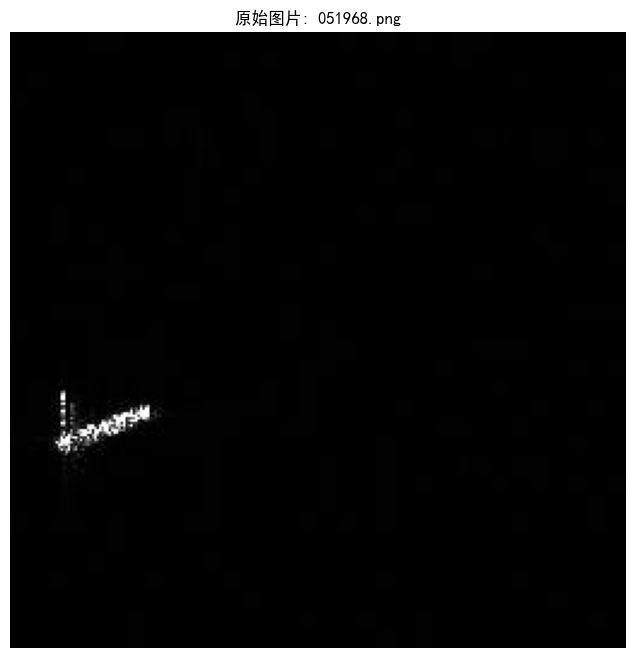

In [3]:
# 使用OpenCV读取图片
image = cv2.imread(str(random_image_path))

if image is not None:
    # OpenCV默认使用BGR格式，转换为RGB以便在matplotlib中正确显示
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    print(f"图片尺寸: {image.shape}")
    print(f"图片类型: {image.dtype}")
    
    # 显示原始图片
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title(f"原始图片: {random_image_path.name}")
    plt.axis('off')
    plt.show()
else:
    print("无法读取图片文件")


In [4]:
# 读取并解析标注文件
def parse_annotation_file(annotation_path):
    """
    解析标注文件，每一行包含8个坐标点
    格式: x1 y1 x2 y2 x3 y3 x4 y4
    """
    annotations = []
    
    if annotation_path.exists():
        with open(annotation_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        print(f"标注文件包含 {len(lines)} 行")
        
        for i, line in enumerate(lines):
            line = line.strip()
            if line:  # 跳过空行
                try:
                    # 分割字符串并转换为浮点数
                    coords = line.split()
                    if len(coords) >= 8:
                        # 提取前8个坐标值
                        coord_values = [float(c) for c in coords[:8]]
                        # 重新组织为4个点的坐标 [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
                        points = [(coord_values[j], coord_values[j+1]) for j in range(0, 8, 2)]
                        annotations.append(points)
                        print(f"第 {i+1} 行解析结果: {points}")
                    else:
                        print(f"第 {i+1} 行坐标点数量不足8个: {coords}")
                except ValueError as e:
                    print(f"第 {i+1} 行解析错误: {line}, 错误: {e}")
    else:
        print("标注文件不存在")
    
    return annotations

# 解析当前选中图片的标注文件
annotations = parse_annotation_file(annotation_path)
print(f"\n总共解析出 {len(annotations)} 个标注框")


标注文件包含 1 行
第 1 行解析结果: [(19.0, 168.0), (57.0, 152.0), (61.0, 162.0), (23.0, 178.0)]

总共解析出 1 个标注框


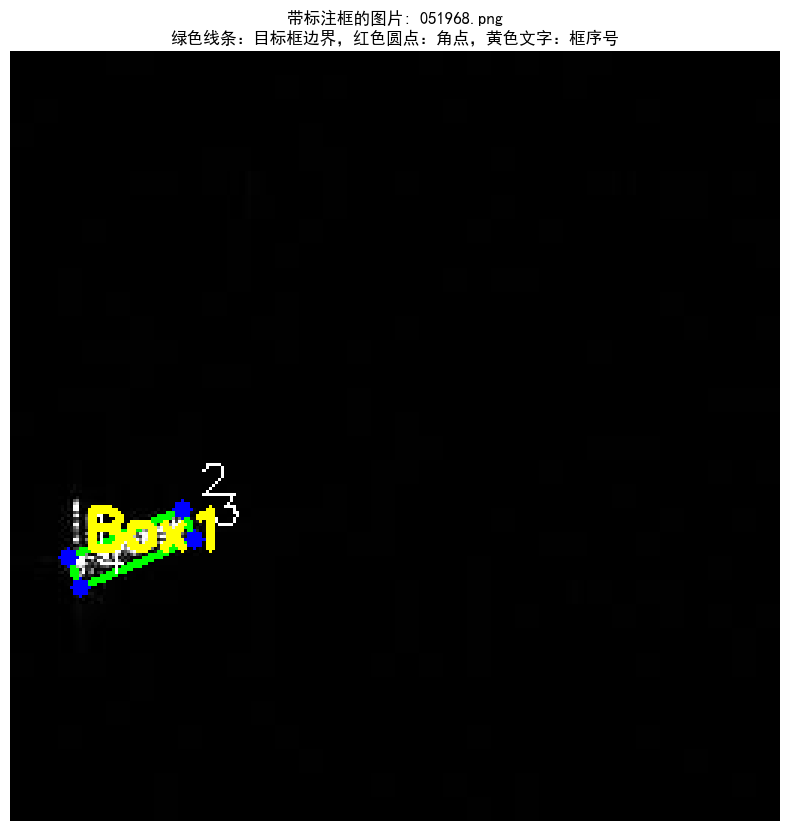

验证说明：
- 绿色线条显示目标框的边界
- 红色圆点标记四个角点位置
- 数字1-4标记角点顺序
- 黄色文字显示框序号
- 请检查绘制的 1 个框是否正确框住图片中的目标


In [5]:
# 在图片上绘制标注框进行验证
def draw_annotations_on_image(image, annotations):
    """
    在图片上绘制标注框
    """
    # 创建图片副本用于绘制
    image_with_annotations = image.copy()
    
    for i, points in enumerate(annotations):
        # 将点坐标转换为numpy数组，并确保为整数类型
        pts = np.array(points, dtype=np.int32)
        
        # 使用cv2.polylines绘制多边形
        cv2.polylines(image_with_annotations, [pts], isClosed=True, 
                     color=(0, 255, 0), thickness=2)
        
        # 在每个角点绘制小圆圈
        for j, (x, y) in enumerate(points):
            cv2.circle(image_with_annotations, (int(x), int(y)), 3, 
                      (255, 0, 0), -1)
            # 标注点的序号
            cv2.putText(image_with_annotations, str(j+1), 
                       (int(x)+5, int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.5, (255, 255, 255), 1)
        
        # 在多边形中心添加框序号
        center_x = int(np.mean([p[0] for p in points]))
        center_y = int(np.mean([p[1] for p in points]))
        cv2.putText(image_with_annotations, f"Box{i+1}", 
                   (center_x-15, center_y), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.6, (0, 255, 255), 2)
    
    return image_with_annotations

# 绘制标注框
if annotations and image is not None:
    image_with_boxes = draw_annotations_on_image(image, annotations)
    
    # 转换为RGB格式显示
    image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    
    # 显示带有标注框的图片
    plt.figure(figsize=(12, 10))
    plt.imshow(image_with_boxes_rgb)
    plt.title(f"带标注框的图片: {random_image_path.name}\n绿色线条：目标框边界，红色圆点：角点，黄色文字：框序号")
    plt.axis('off')
    plt.show()
    
    print("验证说明：")
    print("- 绿色线条显示目标框的边界")
    print("- 红色圆点标记四个角点位置") 
    print("- 数字1-4标记角点顺序")
    print("- 黄色文字显示框序号")
    print(f"- 请检查绘制的 {len(annotations)} 个框是否正确框住图片中的目标")
else:
    print("无标注数据或图片加载失败，无法进行验证")


In [6]:
# 详细的坐标验证信息
print("="*60)
print("详细的坐标验证信息")
print("="*60)

if annotations:
    for i, points in enumerate(annotations):
        print(f"\n标注框 {i+1}:")
        print(f"  四个角点坐标:")
        for j, (x, y) in enumerate(points):
            print(f"    点{j+1}: ({x:.1f}, {y:.1f})")
        
        # 计算边界框信息
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)
        width = max_x - min_x
        height = max_y - min_y
        
        print(f"  边界框范围: x=[{min_x:.1f}, {max_x:.1f}], y=[{min_y:.1f}, {max_y:.1f}]")
        print(f"  边界框尺寸: 宽度={width:.1f}, 高度={height:.1f}")
        
        # 检查坐标是否在图片范围内
        img_height, img_width = image.shape[:2]
        all_in_bounds = all(0 <= x <= img_width and 0 <= y <= img_height 
                           for x, y in points)
        print(f"  坐标范围检查: {'✓ 所有点都在图片范围内' if all_in_bounds else '✗ 有点超出图片范围'}")
        
print(f"\n图片尺寸: {image.shape[1]} x {image.shape[0]} (宽 x 高)")
print("\n验证要点:")
print("1. 检查绿色多边形框是否紧密贴合目标物体")
print("2. 验证红色角点是否准确标记目标的四个角")
print("3. 确保所有坐标点都在图片范围内")
print("4. 如果框的位置明显错误，说明坐标解析逻辑需要调整")


详细的坐标验证信息

标注框 1:
  四个角点坐标:
    点1: (19.0, 168.0)
    点2: (57.0, 152.0)
    点3: (61.0, 162.0)
    点4: (23.0, 178.0)
  边界框范围: x=[19.0, 61.0], y=[152.0, 178.0]
  边界框尺寸: 宽度=42.0, 高度=26.0
  坐标范围检查: ✓ 所有点都在图片范围内

图片尺寸: 256 x 256 (宽 x 高)

验证要点:
1. 检查绿色多边形框是否紧密贴合目标物体
2. 验证红色角点是否准确标记目标的四个角
3. 确保所有坐标点都在图片范围内
4. 如果框的位置明显错误，说明坐标解析逻辑需要调整


## 数据探索总结

### 完成的任务：
1. ✅ 随机选择训练图片并使用OpenCV读取显示
2. ✅ 找到对应的.txt标注文件  
3. ✅ 解析标注文件中的8个坐标点并转换为浮点数数组
4. ✅ 使用cv2.polylines在图片上绘制多边形框进行验证

### 坐标解析逻辑：
- 每行标注数据包含8个数值：`x1 y1 x2 y2 x3 y3 x4 y4`
- 转换为4个点的坐标对：`[(x1,y1), (x2,y2), (x3,y3), (x4,y4)]`
- 使用`cv2.polylines`绘制封闭多边形

### 验证要点：
- **关键验证**：绘制的绿色多边形框应该完美贴合图片中的目标物体
- 如果框的位置不正确，可能的原因：
  1. 坐标解析顺序错误
  2. 坐标系不匹配（可能需要坐标变换）
  3. 标注文件格式理解有误

### 调试建议：
如果发现框的位置不对，可以尝试：
1. 检查坐标点的连接顺序
2. 验证坐标系统（原点位置、坐标轴方向）
3. 确认标注文件的具体格式规范


### 🔧 Bug修复说明

**修复的问题:**
1. **NameError: 'idx' is not defined** - 在`_parse_annotations`方法中传递`idx`参数
2. **NameError: 'math' is not defined** - 在notebook中添加`math`模块导入  
3. **RuntimeError: tensor尺寸不一致** - 添加图片resize功能，统一所有图片为512x512尺寸

**主要改进:**
- 数据集现在会自动将所有图片resize到统一尺寸
- 标注坐标会相应缩放以匹配resize后的图片
- 支持批量加载而不会出现尺寸冲突


## 测试数据加载器 SARDataset

现在测试我们创建的数据加载器，验证8点坐标到旋转框转换的正确性。


In [7]:
# 导入数据加载器相关库
import sys
sys.path.append('../src')  # 添加src路径以便导入dataset模块

import torch
from torch.utils.data import DataLoader
from dataset import SARDataset, collate_fn

# 实例化数据集（现在会将所有图片resize到512x512）
dataset = SARDataset(
    images_dir="../data/train/images",
    annotations_dir="../data/train/annfiles",
    image_size=(512, 512)  # 统一图片尺寸，解决tensor stack错误
)

print(f"数据集大小: {len(dataset)}")
print(f"类别映射: {dataset.class_to_id}")
print(f"可用类别数: {len(dataset.class_to_id)}")


数据集初始化完成，共找到 89082 个有效样本
数据集大小: 89082
类别映射: {'ship': 0, 'bridge': 1, 'aircraft': 2, 'tank': 3, 'vehicle': 4, 'harbor': 5, 'building': 6}
可用类别数: 7


In [8]:
# 测试单个样本
import math  # 添加math模块导入

if len(dataset) > 0:
    sample_idx = 0
    image_tensor, targets = dataset[sample_idx]
    
    print(f"样本 {sample_idx} 信息:")
    print(f"图片张量形状: {image_tensor.shape}")
    print(f"图片张量类型: {image_tensor.dtype}")
    print(f"图片数值范围: [{image_tensor.min():.3f}, {image_tensor.max():.3f}]")
    
    print(f"\n目标信息:")
    print(f"目标框数量: {len(targets['boxes'])}")
    print(f"目标框形状: {targets['boxes'].shape}")
    print(f"标签形状: {targets['labels'].shape}")
    
    print(f"\n详细目标框信息:")
    for i, (box, label) in enumerate(zip(targets['boxes'], targets['labels'])):
        cx, cy, w, h, angle = box
        class_name = dataset.get_class_name(label.item())
        print(f"  目标{i+1}: 类别={class_name}({label.item()})")
        print(f"          中心点=({cx:.3f}, {cy:.3f})")
        print(f"          尺寸={w:.3f}x{h:.3f}")
        print(f"          角度={angle:.3f}弧度 ({math.degrees(angle):.1f}度)")
else:
    print("数据集为空")


样本 0 信息:
图片张量形状: torch.Size([3, 512, 512])
图片张量类型: torch.float32
图片数值范围: [0.000, 0.996]

目标信息:
目标框数量: 1
目标框形状: torch.Size([1, 5])
标签形状: torch.Size([1])

详细目标框信息:
  目标1: 类别=ship(0)
          中心点=(0.689, 0.607)
          尺寸=0.128x0.052
          角度=1.093弧度 (62.7度)


In [9]:
# 修复numpy兼容性问题 - 重新定义可视化函数
def visualize_rotated_boxes(image_tensor, targets, sample_idx):
    """
    可视化旋转框，验证8点坐标转换是否正确
    """
    # 将tensor转换回numpy数组用于显示
    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)
    
    # 获取图片尺寸
    height, width = image_np.shape[:2]
    
    # 在图片上绘制旋转框
    image_with_boxes = image_np.copy()
    
    for i, (box, label) in enumerate(zip(targets['boxes'], targets['labels'])):
        # 反归一化坐标
        cx = box[0].item() * width
        cy = box[1].item() * height
        w = box[2].item() * width
        h = box[3].item() * height
        angle = box[4].item()
        
        # 使用OpenCV的旋转矩形绘制
        center = (cx, cy)
        size = (w, h)
        angle_deg = math.degrees(angle)
        
        # 获取旋转矩形的4个角点
        rect = (center, size, angle_deg)
        box_points = cv2.boxPoints(rect)
        box_points = box_points.astype(np.int32)  # 修复numpy版本兼容性问题
        
        # 绘制旋转框
        cv2.drawContours(image_with_boxes, [box_points], 0, (0, 255, 0), 2)
        
        # 绘制中心点
        cv2.circle(image_with_boxes, (int(cx), int(cy)), 3, (255, 0, 0), -1)
        
        # 添加类别标签
        class_name = dataset.get_class_name(label.item())
        cv2.putText(image_with_boxes, f"{class_name}", 
                   (int(cx-20), int(cy-10)), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (255, 255, 0), 1)
    
    # 显示图片
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes)
    plt.title(f"样本 {sample_idx}: 旋转框可视化验证\n绿色框：转换后的旋转框，蓝色点：中心点，黄色：类别")
    plt.axis('off')
    plt.show()
    
    return image_with_boxes

print("✅ 可视化函数已修复numpy兼容性问题")


✅ 可视化函数已修复numpy兼容性问题


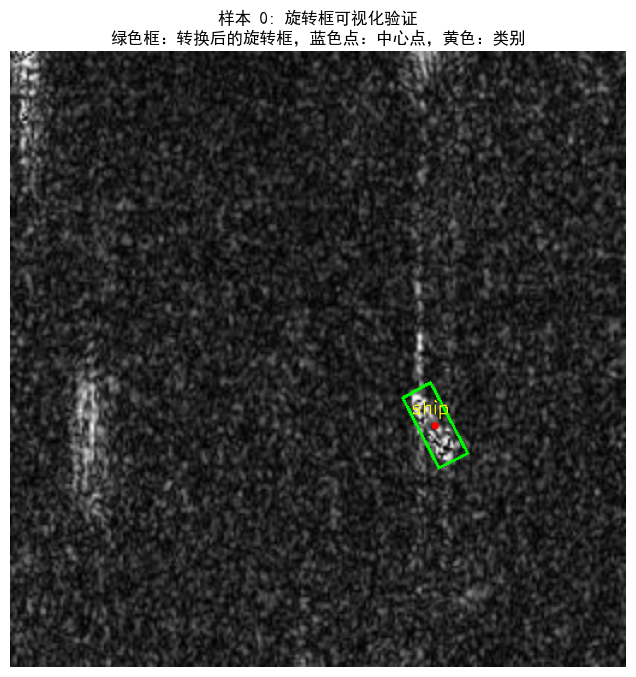

可视化验证完成!
请检查:
1. 绿色旋转框是否正确框住目标物体
2. 蓝色中心点是否位于目标中心
3. 类别标签是否正确
4. 如果框的位置或角度不对，说明坐标转换逻辑需要调整


In [10]:
# 重新运行可视化验证（使用修复后的函数）
if len(dataset) > 0:
    image_tensor, targets = dataset[0]
    visualized_image = visualize_rotated_boxes(image_tensor, targets, 0)
    
    print("可视化验证完成!")
    print("请检查:")
    print("1. 绿色旋转框是否正确框住目标物体")
    print("2. 蓝色中心点是否位于目标中心")
    print("3. 类别标签是否正确")
    print("4. 如果框的位置或角度不对，说明坐标转换逻辑需要调整")


In [11]:
# 创建DataLoader并测试批量加载
# 现在所有图片都是512x512尺寸，可以正常stack
dataloader = DataLoader(
    dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=0  # Windows下建议设为0
)

print("测试DataLoader:")
print(f"DataLoader批次大小: {dataloader.batch_size}")

# 获取一个批次的数据
try:
    batch_images, batch_targets = next(iter(dataloader))
    
    print(f"\n批次数据信息:")
    print(f"图片批次形状: {batch_images.shape}")
    print(f"图片批次类型: {batch_images.dtype}")
    print(f"目标数量: {len(batch_targets)}")
    
    print(f"\n每个样本的目标框数量:")
    for i, targets in enumerate(batch_targets):
        print(f"  样本{i+1}: {len(targets['boxes'])}个目标框, 类别: {targets['labels'].tolist()}")
        
    print("\n✅ DataLoader测试成功！")
    
except Exception as e:
    print(f"❌ DataLoader测试失败: {e}")
    import traceback
    traceback.print_exc()


测试DataLoader:
DataLoader批次大小: 4

批次数据信息:
图片批次形状: torch.Size([4, 3, 512, 512])
图片批次类型: torch.float32
目标数量: 4

每个样本的目标框数量:
  样本1: 1个目标框, 类别: [1]
  样本2: 3个目标框, 类别: [0, 0, 0]
  样本3: 1个目标框, 类别: [0]
  样本4: 1个目标框, 类别: [5]

✅ DataLoader测试成功！


## 数据加载器测试总结

### ✅ 完成的功能：

1. **SARDataset类实现**：
   - 继承自`torch.utils.data.Dataset`
   - 实现了`__init__`、`__len__`、`__getitem__`方法
   - 支持图片和标注文件的自动配对

2. **核心转换功能**：
   - 8点坐标转换为旋转框表示 `(cx, cy, width, height, angle)`
   - 使用`cv2.minAreaRect`计算最小外接旋转矩形
   - 坐标归一化处理

3. **类别映射**：
   - 类别名称到整数ID的映射
   - 支持多种SAR目标类别（ship, bridge, aircraft等）

4. **DataLoader集成**：
   - 自定义`collate_fn`处理变长标注
   - 支持批量加载和数据洗牌

5. **可视化验证**：
   - 显示转换后的旋转框
   - 验证坐标转换的正确性

### 🎯 关键验证点：
- 检查绿色旋转框是否准确框住目标
- 验证角度计算是否正确
- 确保类别映射无误
- 测试批量加载功能

数据加载器已准备就绪，可用于训练SAR目标检测模型！
